<a href="https://colab.research.google.com/github/Ngueyap/Projet-HDH/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question1

In [ ]:
# Importer les bibliothèques nécessaires
from sqlalchemy import create_engine, Column, Integer, String, text, update, select
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

# Créer une instance du moteur SQL
engine = create_engine('sqlite:///sante_data.db')

# Créer une session SQLAlchemy
Session = sessionmaker(bind=engine)
session = Session()

# Créer une classe de base pour les objets de la base de données
Base = declarative_base()


# Définir la classe pour la table "person"
class Person(Base):
    __tablename__ = 'person'

    person_id = Column(Integer, primary_key=True)
    person_source_value = Column(String)
    gender_concept_id = Column(Integer)
    year_of_birth = Column(Integer)  # Cette colonne sera remplie ultérieurement

# Créer la table dans la base de données
Base.metadata.create_all(engine)




<ipython-input-1-aac2afef74b1>:14: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


Question 2

In [ ]:
import pandas as pd

class DataCleaner:
    def __init__(self, file_path, delimiter):
        self.data = pd.read_csv(file_path, sep=delimiter)

    def get_num_rows_before_cleaning(self):
        return len(self.data)

    def remove_duplicates(self):
        self.data = self.data.drop_duplicates()

    def remove_missing_values(self):
        self.data = self.data.dropna()

    def get_cleaned_data(self):
        return self.data

    def get_distri_sexe(self):
        return self.data['COD_SEX'].value_counts()

    def map_sex_codes(self):
        # Remplacez les valeurs de COD_SEX selon votre codification
        sex_mapping = {1: 'Homme', 2: 'Femme', 0: 'Indéterminé', 9: 'Indéterminé'}
        self.data['COD_SEX'] = self.data['COD_SEX'].map(sex_mapping)



# Utilisation de la classe pour nettoyer deux fichiers CSV
if __name__ == '__main__':
    file_path1 = 'T_MCOaaC.csv'
    file_path2 = 'T_MCOaaB.csv'

    # Définisser le délimiteur pour chaque fichier
    delimiter2 = ','  # Délimiteur pour le premier fichier
    delimiter1 = '|'  # Délimiteur pour le second fichier

    # Créer les instances de DataCleaner en spécifiant les délimiteurs
    cleaner1 = DataCleaner(file_path1, delimiter1)
    cleaner2 = DataCleaner(file_path2, delimiter2)
    num_rows_before_cleaning1 = cleaner1.get_num_rows_before_cleaning()
    cleaner1.remove_duplicates()
    cleaner1.remove_missing_values()
    cleaned_data1 = cleaner1.get_cleaned_data()



    num_rows_before_cleaning2 = cleaner2.get_num_rows_before_cleaning()
    cleaner2.remove_duplicates()
    cleaner2.remove_missing_values()
    cleaned_data2 = cleaner2.get_cleaned_data()

    # Traitement de la colonne COD_SEX
    cleaner2.map_sex_codes()


    # nombres de lignes
    print(f"Nombre de lignes avant le nettoyage pour le fichier 1 : {num_rows_before_cleaning1}, "
          f"Nombre de lignes après le nettoyage : {len(cleaned_data1)}")
    print(f"Nombre de lignes avant le nettoyage pour le fichier 2 : {num_rows_before_cleaning2}, "
          f"Nombre de lignes après le nettoyage : {len(cleaned_data2)}")
    print("Distribution homme/femme dans T_MCOAAB :\n", cleaner2.get_distri_sexe())

Nombre de lignes avant le nettoyage pour le fichier 1 : 542, Nombre de lignes après le nettoyage : 514
Nombre de lignes avant le nettoyage pour le fichier 2 : 520, Nombre de lignes après le nettoyage : 513
Distribution homme/femme dans T_MCOAAB :
 Femme          190
Homme          165
Indéterminé    158
Name: COD_SEX, dtype: int64


Question3

In [ ]:
# Insérer les valeurs de la colonne NIR_ANO_17 dans la table person
for index, row in cleaned_data1.iterrows():
    nir_ano_17 = row['NIR_ANO_17']

    # Créer une nouvelle instance de Person pour chaque valeur NIR_ANO_17
    person = Person(person_source_value=nir_ano_17)

    # Ajouter cette instance à la session
    session.add(person)

# Valider les insertions
session.commit()

Question 4

In [ ]:
# Effectuer la jointure entre les DataFrames T_MCOAAC et T_MCOAAB en utilisant les clés de jointure ETA_NUM et RSA_NUM
merged_data = pd.merge(cleaned_data1, cleaned_data2, on=['ETA_NUM'], how='inner')
# Définisser le mapping entre les valeurs de sexe SNDS classique et OMOP-CDM
sex_mapping = {
    'Homme': 8507,  # Homme selon OMOP-CDM
    'Femme': 8532,  # Femme selon OMOP-CDM
    # Ajoutez d'autres mappages si nécessaire
}
# Appliquer le mapping et mettez à jour la colonne gender_concept_id dans la table person
for index, row in merged_data.iterrows():
    NIR_ANO_17 = row['NIR_ANO_17']
    sexe_snds = row['COD_SEX']

    # Vérifier si le sexe SNDS classique est défini
    if sexe_snds in sex_mapping:
        # Metter à jour la colonne gender_concept_id
        session.query(Person).filter(Person.person_source_value == NIR_ANO_17).update({"gender_concept_id": sex_mapping[sexe_snds]})

# Enlever les patients pour qui le sexe n'est pas défini dans le SNDS classique
session.query(Person).filter(Person.gender_concept_id.is_(None)).delete()
session.commit()

Question 5

In [ ]:
# Supprimer les doublons sur la colonne person_source_value
query = text('''
    Delete FROM person
    WHERE person_id NOT IN (
        SELECT MIN(person_id)
        FROM person
        GROUP BY person_source_value
        HAVING COUNT(*) > 1
    )
''')
session.execute(query)
session.commit

# Mettre à jour la colonne Person_id
# SélectionneR tous les enregistrements triés par 'person_id' de manière ascendante
records = session.query(Person).order_by(Person.person_id).all()

# Nouvel ID initial
new_id = 1

# ParcourIR les enregistrements et attribuez un nouvel ID séquentiel à chaque enregistrement
for record in records:
    # Mettez à jour 'person_id' avec le nouvel ID
    record.person_id = new_id
    new_id += 1


session.commit()

Question6

In [ ]:
# METTRE 'EXE_SOI_DTD' est déjà au format datetime
merged_data['EXE_SOI_DTD']= pd.to_datetime(merged_data['EXE_SOI_DTD'], format='%d%b%Y:%H:%M:%S')

# cALCUL DE L'age
from dateutil.relativedelta import relativedelta
merged_data['birth_date']= merged_data['EXE_SOI_DTD'].dt.date-merged_data['AGE_ANN'].apply(lambda y: relativedelta(years=y))

for index, row in merged_data.iterrows():
    person_source_value = row['NIR_ANO_17']
    birth_date = row['birth_date']
    # Créez une instruction de mise à jour
    update_statement = update(Person).where(Person.person_source_value == person_source_value).values(year_of_birth=birth_date)

    # Exécutez la mise à jour
    session.execute(update_statement)

session.commit

<bound method Session.commit of <sqlalchemy.orm.session.Session object at 0x7abfa5b57c70>>

In [ ]:
query = text('select *  from person')


# Exécuter la requête SELECT en utilisant la session
duplicates = session.execute(query)

# ParcourIR les résultats pour obtenir les doublons
for row in duplicates:
    print(row.person_id, row.person_source_value, row.gender_concept_id, row.year_of_birth)



1 fiosftusfZACfuNhE 8507 1919-07-10
2 pTzHiYhikHWhkIIKu 8532 1951-06-13
3 lfQvrRwJWWSwgKiKh 8532 1920-12-16
4 LqgAzcvGjjokflOzN 8532 1913-12-08
5 fUjvhXqgHxhzIcZUV 8532 1926-01-18
6 MmWEyevQtWEtwYnZT 8532 1880-11-15
7 HxbMiGPkIcNbbxgHD 8532 1887-10-05
8 iFoRwhprfLBIyxCxO 8532 1904-03-10
9 EWsJuBZVXYjPjGHuv 8532 1889-02-21
10 OjkjMtKgaNWGzgMBt 8532 1910-09-04
11 KFaQejdWYHUTDkpcD 8532 1958-05-10
12 WYJjxkqwmqOmlRdTW 8507 1967-04-08
13 SWiIFwXRNFkwXWuHz 8532 1952-03-31
14 NZKwdbuWNoyNyfynT 8532 1954-06-28
15 BRDIBOcmZaFRfgyxP 8532 1868-04-08
16 jlxHDqxUWgGtMkCeW 8507 1963-06-28
17 JoOvWOTlkKmqsdQli 8507 1923-07-05
18 SmhgNiVqEmYaXzhdI 8507 1894-01-20
19 lYQcBYGQSYPGjebQB 8507 1907-08-04
20 kZdpxMDzRRWmUQCkb 8507 1991-01-14
21 mXDLkVKtmCVkhIYkg 8507 1946-12-03
22 eZpnYdlIFKOdvrSoR 8507 2009-11-18
23 ZdYOEoBxluCntBWVs 8532 1959-07-10
24 OmGnVKNDBzcowsYnz 8532 1892-03-05
25 KpEPISHilApknOjPk 8532 1990-04-14
26 WsggWmVVSzfWAPKhI 8532 1949-04-26
27 dmRbBIcUFxtHkYzsh 8507 1921-06-27
28 HpXqlxq

Question 7

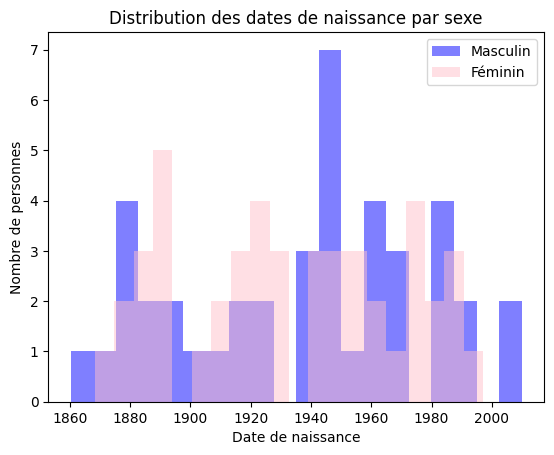

In [ ]:
import matplotlib.pyplot as plt
query = text('select *  from person')


# Exécuter la requête SELECT en utilisant la session
results = session.execute(query)


# Créer des listes pour les dates de naissance en fonction du sexe
birth_dates_M = []
birth_dates_F = []

# Parcourir les résultats et triez les dates de naissance en fonction du sexe
for  row in results:
    gender = row.gender_concept_id
    birth_date = row.year_of_birth

    if gender == 8507:  # Supposez que 8507 représente le code pour le sexe masculin
        birth_dates_M.append(birth_date)
    elif gender == 8532:  # Supposez que 8532 représente le code pour le sexe féminin
        birth_dates_F.append(birth_date)

# Convertir les listes de dates de naissance en objets datetime
birth_dates_M = [pd.to_datetime(date) for date in birth_dates_M]
birth_dates_F = [pd.to_datetime(date) for date in birth_dates_F]

# Créer une figure et un axe pour le graphique
fig, ax = plt.subplots()

# Générer un histogramme pour les dates de naissance masculines
ax.hist(birth_dates_M, bins=20, alpha=0.5, label='Masculin', color='blue')

# Générer un histogramme pour les dates de naissance féminines
ax.hist(birth_dates_F, bins=20, alpha=0.5, label='Féminin', color='pink')

# Ajoutez des étiquettes et une légende
ax.set_xlabel('Date de naissance')
ax.set_ylabel('Nombre de personnes')
ax.set_title('Distribution des dates de naissance par sexe')
ax.legend()

# Sauvegardez la figure
plt.savefig('distribution_dates_de_naissance.png')

# Affichez la figure
plt.show()
